<a href="https://colab.research.google.com/github/krishan-23/Collage___Project/blob/main/Collage23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown
!pip install --upgrade gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0


In [ ]:
!gdown --id 1L-YpU_ajchM52MS2novpOpwRMOv5S75B&confirm=t -O /content/ --folder

/bin/bash: line 1: -O: command not found
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1L-YpU_ajchM52MS2novpOpwRMOv5S75B
From (redirected): https://drive.google.com/uc?id=1L-YpU_ajchM52MS2novpOpwRMOv5S75B&confirm=t&uuid=955ac2ab-2bf4-4601-8915-7fec479c0e19
To: /content/COVID.zip
100% 995M/995M [00:18<00:00, 53.0MB/s]


In [ ]:
!unzip -q COVID.zip   #unzips the zip file
!rm COVID.zip     #removes the original zip file

In [ ]:
# import system modules
import os
import sys
import datetime
import random

# import external helpful libraries
import tensorflow as tf
import numpy as np
import cv2    #OpenCV - computer vision library
import matplotlib.pyplot as plt

import keras
from keras.models import Model, save_model, load_model
from keras.layers import Dense, Dropout, Activation
#from keras.layers import Input, UpSampling2D, concatenate
from keras.optimizers import Adam, SGD
from keras.callbacks import Callback, TensorBoard
from keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator

# possible libraries for metrics
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, classification_report,confusion_matrix

%load_ext tensorboard

In [ ]:
np.random.seed(1)           #set random seed
tf.random.set_seed(1)

In [ ]:
# define a function for splitting the data

def make_val_set(path, percent):
    path = path if path[-1] == '/' else path+'/'          #add a  / if there isn't one
    images = os.listdir(f"{path}train")                 #define the source image directory
    for image in images:                              #for each subfolder in the source image directory
        os.makedirs(f"{path}val/{image}", exist_ok=True)  #make a directory called val/subfolder, ignore if it already exists
        file_list = os.listdir(f"{path}train/{image}")  #make a list of images in source
        random.shuffle(file_list)                       #shuffle the list
        num_files = int(len(file_list)*percent)         #count the files and multiply by the percent
        val_set = [file_list[n] for n in range(num_files)]  #Add n files to val_set
        for file in val_set:
            os.rename(f"{path}train/{image}/{file}", f"{path}val/{image}/{file}") #move each file in val_set to the val/ directory

In [ ]:
# Call the function and provide it with the location (path) of the data and the percentage you want

make_val_set('/content/Data/', 0.2)   #Take 20% of the data for validation

In [ ]:
# create variables that hold the location of your data folders
train_path = '/content/Data/train/'
val_path = '/content/Data/val/'
test_path = '/content/Data/test/'

# the CNN we will be using is built for 224x224 sized images
# create a variable that holds the image size
img_size = (224, 224)

# set batch size
batch = 32

# create data generators. I will perform data augmentation on the training set.
train_data_gen = ImageDataGenerator(
      rotation_range = 15,          #rotate image by up to 15 degrees
      width_shift_range=0.1,        #change image width by up to 10%
      height_shift_range=0.1,       #change image height by up to 10%
      brightness_range=[0.9, 1.1],  #change brightness by up to 10%
      zoom_range=0.1,               #zoom in by up to 10%
      horizontal_flip=True,         #flip some images horizontally
      rescale=1.0/255.0             #Normalize the pixel values (I want them to be from 0.0 to 1.0) **VERY IMPORTANT
      )
val_data_gen = ImageDataGenerator(rescale=1.0/255.0)  #validation generator, normalize pixel values
test_data_gen = ImageDataGenerator(rescale=1.0/255.0) #test generator, normalize pixel values

#activate the generators, providing the PATH, IMAGE SIZE, BATCH SIZE, CLASSIFICATION TYPE
train_generator = train_data_gen.flow_from_directory(train_path, target_size=img_size, batch_size=batch, class_mode='categorical')
val_generator = val_data_gen.flow_from_directory(val_path, target_size=img_size, batch_size=batch, class_mode='categorical')
test_generator = test_data_gen.flow_from_directory(test_path, target_size=img_size, batch_size=batch, class_mode='categorical')

Found 4116 images belonging to 3 classes.
Found 1028 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [ ]:
# define a function to create our model
def CheXNet_model(input_shape):
    CheXNet = DenseNet121(include_top=True, weights=None, input_shape=input_shape, classes=14)          #Create an untrained CheXNet. CheXNet was originally trained to detect 14 classes
    CheX_model = Model(inputs=CheXNet.input, outputs=CheXNet.layers[-1].output, name='CheXNet_base')    #Create a new model that takes the CheXNet inputs as inputs, and outputs of the last layer as outputs
    CheX_model.load_weights('/content/CheXNet weights.h5')      #load the pre-trained weights
    CheX_model.trainable = False                          #set the pre-trained layers as untrainable
    x = CheX_model.layers[-2].output                      #create a variable x to hold the output of the 2nd last layer of CheXNet
    x = Dense(1024, activation='relu', name='fc1')(x)     #add a new trainable layer that takes x as input, and update x
    x = Dense(512, activation='relu', name='fc2')(x)      #add a new trainable layer that takes x as input, and update x
    x = Dense(256, activation='relu', name='fc3')(x)      #add a new trainable layer that takes x as input, and update x
    x = Dropout(0.4, name='dropout')(x)                   #add a dropout layer that takes x as input, and update x
    x = Dense(3, activation='softmax', name='fc4')(x)     #add our classification layer that takes x as input, and update x

    model = Model(inputs=CheX_model.input, outputs=x, name='CheXNet_modified')    # Create our final model with inputs and outputs
    return model


model = CheXNet_model((224, 224, 3))    #initialize the model with the input shape (height, width, colour channels)
model.summary()   #print out a summary of the model



Model: "CheXNet_modified"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0]

In [ ]:
learning_rate = 0.0001
epochs = 10
optimizer = Adam(learning_rate)

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=optimizer)

In [ ]:
history = model.fit(train_generator, epochs=epochs, verbose = 1, validation_data=val_generator)

Epoch 1/10
129/129 [==============================] - 1039s 8s/step - loss: 0.6749 - accuracy: 0.7281 - val_loss: 0.5183 - val_accuracy: 0.8142
Epoch 2/10
129/129 [==============================] - 1011s 8s/step - loss: 0.5091 - accuracy: 0.8022 - val_loss: 0.3792 - val_accuracy: 0.8453
Epoch 3/10
129/129 [==============================] - 1013s 8s/step - loss: 0.4068 - accuracy: 0.8445 - val_loss: 0.3879 - val_accuracy: 0.8375
Epoch 4/10
129/129 [==============================] - 1054s 8s/step - loss: 0.3792 - accuracy: 0.8496 - val_loss: 0.2970 - val_accuracy: 0.8911
Epoch 5/10
129/129 [==============================] - 1031s 8s/step - loss: 0.3521 - accuracy: 0.8652 - val_loss: 0.2815 - val_accuracy: 0.8959
Epoch 6/10
129/129 [==============================] - 1076s 8s/step - loss: 0.3349 - accuracy: 0.8715 - val_loss: 0.2568 - val_accuracy: 0.9047
Epoch 7/10
129/129 [==============================] - 1066s 8s/step - loss: 0.3308 - accuracy: 0.8700 - val_loss: 0.2916 - val_accuracy:

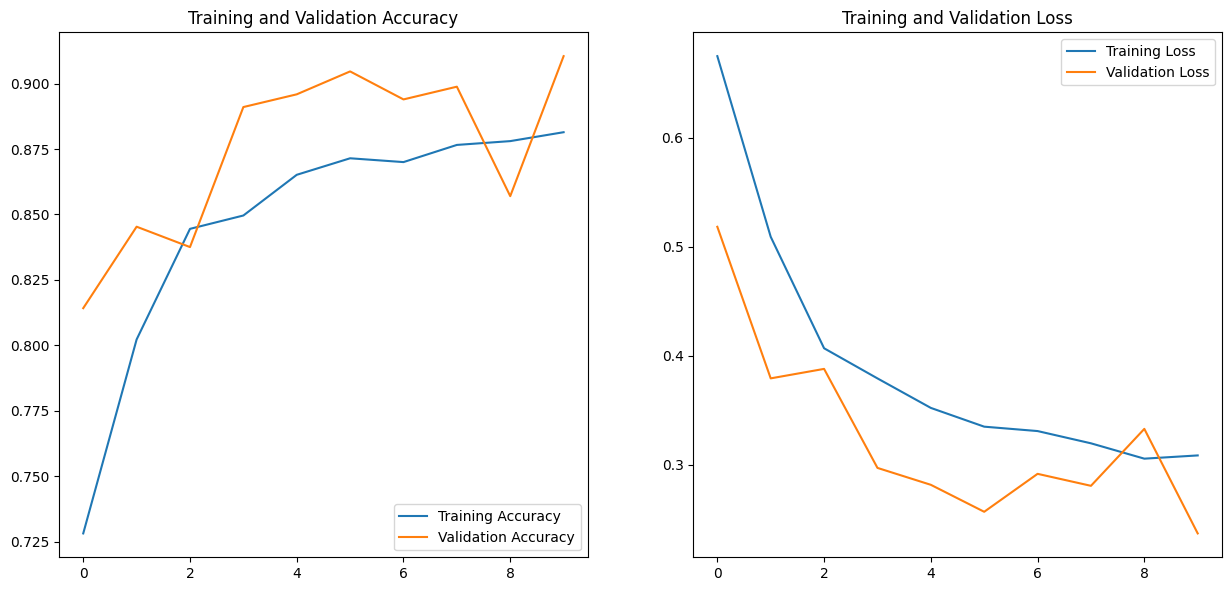

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.evaluate(test_generator)

41/41 [==============================] - 244s 6s/step - loss: 0.2613 - accuracy: 0.8998


[0.26125413179397583, 0.8998447060585022]

In [14]:
save_path = '/content/saved_model/'
save_model(model, save_path)

In [15]:
!zip -r '/content/saved_model.zip' '/content/saved_model'

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/assets/ (stored 0%)
  adding: content/saved_model/saved_model.pb (deflated 92%)
  adding: content/saved_model/fingerprint.pb (stored 0%)
  adding: content/saved_model/keras_metadata.pb (deflated 96%)
  adding: content/saved_model/variables/ (stored 0%)
  adding: content/saved_model/variables/variables.data-00000-of-00001 (deflated 14%)
  adding: content/saved_model/variables/variables.index (deflated 80%)


In [16]:
!unzip -q '/content/saved_model.zip'
!rm '/content/saved_model.zip'

In [18]:
save_path = '/content/content/saved_model/'
model = load_model(save_path, compile=True)

In [22]:
predict_path = '/content/predict'
img_size = (224, 224)
xray_images = os.listdir(predict_path)
print(xray_images)

['NORMAL(1304).jpg', 'COVID19(489).jpg', 'PNEUMONIA(3433).jpg', 'COVID19(488).jpg', 'PNEUMONIA(3434).jpg', 'NORMAL(1305).jpg', 'COVID19(490).jpg', 'PNEUMONIA(3432).jpg']


In [23]:
data_predict = []                                   # create and empty list
for xray in xray_images:
  xray_path = os.path.join(predict_path, xray)      # provide the path for each image file
  xray_img = cv2.imread(xray_path)                  # read the image files as images
  xray_img = xray_img.astype(np.float32)/255        # normalize the pixel values
  xray_img = cv2.resize(xray_img, img_size)         # resize the images to our image size as defined above
  data_predict.append(xray_img)                     # add the image to the empty list
xray_predictions = np.array(data_predict)           # convert the list to a numpy array

predictions = model.predict(xray_predictions)       # use the model to predict the classes of each image
print(predictions)                                  # print out the results

1/1 [==============================] - 6s 6s/step
[[1.6399310e-04 9.7324067e-01 2.6595376e-02]
 [6.5133375e-01 1.7313306e-03 3.4693485e-01]
 [4.5325348e-04 3.6700574e-01 6.3254100e-01]
 [9.4511312e-01 9.2913874e-04 5.3957641e-02]
 [2.6628966e-04 3.6885750e-03 9.9604499e-01]
 [4.5253037e-04 9.1844594e-01 8.1101514e-02]
 [1.0066897e-01 3.8648624e-02 8.6068249e-01]
 [1.4376722e-03 5.2378350e-03 9.9332446e-01]]


In [24]:
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']        # define our class names

for xray in predictions:
  xray_prediction = classes[np.argmax(xray)]        # to make the ouput readable, we take the class with the maximum probability value and map it to our class names.
  print(xray_prediction)

NORMAL
COVID19
PNEUMONIA
COVID19
PNEUMONIA
NORMAL
PNEUMONIA
PNEUMONIA
